In [1]:
# !pip install marigold
import sys
import time
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
from tqdm.auto import tqdm
import os                                    #Min ting
import arpesnet as an
import numpy as np

from knano.cluster import Cluster

In [2]:
print("Loading trainer")
trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\General coding stuff\ARPES_on_the_fly_arpesnet_206c328\trained_model\arpesnet_n2n_4k.pth"
# trainerPath = r"C:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\Deres\ARPES_on_the_fly_arpesnet_206c328\trained_by_me\arpesnet_60epochs_001.pt"
trainer = an.core.load_trainer(trainerPath)
print("Trainer loaded\n")

encoder = trainer.encoder
decoder = trainer.decoder

encoder.eval()
decoder.eval()

def useARPES_on_img(img):
    rec = decoder(encoder(img.unsqueeze(0))).detach().squeeze().cpu().numpy()
    return rec
print("Machine learning reconstruction is ready")

Loading trainer


c:\Users\Alexa\anaconda3\lib\site-packages\arpesnet\core.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(filepath)
c:\Users\Alexa\anaconda3\lib\site

GPU not available, using CPU
Trainer loaded

Machine learning reconstruction is ready


In [3]:
INPUT_SHAPE = (256, 256)
NORM_RANGE = (0, 100)
preprocess = an.transform.Compose(
    [an.transform.Resize(INPUT_SHAPE), an.transform.NormalizeMinMax(*NORM_RANGE)]
)

# ROOT_DIR = Path(os.path.dirname(os.path.abspath(__file__))) / "ARPES_on_the_fly_arpesnet_206c328" / "data"
ROOT_DIR = Path(os.getcwd()) / "ARPES_on_the_fly_arpesnet_206c328" / "data"
TRAINING_DIR = ROOT_DIR / "train_data" / "train_data"
TEST_DIR = ROOT_DIR / "test_data" / "test_data"
TEST_IMGS_FILE = ROOT_DIR / "test_imgs.pt"
CLUSTER_CENTER_FILE = ROOT_DIR / "cluster_centers.pt"

def getImgFromName(name, range=(0, 0), sum=False):    #Denne fuktion kigger bare igennem de forskellige data- filer og mapper og returnerer de tilhørende billeder.
    imgName = ""
    imgPath = ""
    if (name == "test_imgs.pt"):
        imgName = "test_imgs.pt"
        imgPath = ROOT_DIR
    elif (name == "cluster_centers.pt"):
        imgName = "cluster_centers.pt"
        imgPath = ROOT_DIR
    else:
        paths = [TRAINING_DIR, TEST_DIR]
        for dir in paths:
            if (name in os.listdir(dir)):
                imgName = name
                imgPath = dir
                break
    
    if(imgName == ""):
        print(f'Datafile with name: "{name}" was not found')
        exit()

    print(imgPath / name)
    imgs = torch.load(imgPath / name)

    if(range==(0, 0)): preprocessed = torch.stack([preprocess(img) for img in tqdm(imgs)])
    else:              preprocessed = torch.stack([preprocess(img) for img in tqdm(imgs)][range[0]:range[1]])
    if(sum):
        preprocessed = [torch.sum(preprocessed, dim=0)]


    return name, preprocessed


imgName, test_imgs = getImgFromName("test_imgs.pt", sum=False, range=(0, 1))

c:\Users\Alexa\Dropbox\Pc\Documents\Privat\Programering\Visual studio\Uni\Bachelor\General coding stuff\ARPES_on_the_fly_arpesnet_206c328\data\test_imgs.pt


C:\Users\Alexa\AppData\Local\Temp\ipykernel_10088\3685095879.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  imgs = torch.load(imgPath / name)


  0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\Alexa\anaconda3\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1.3597168922424316


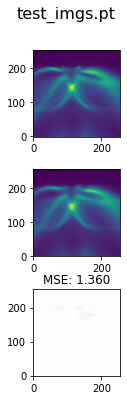

In [4]:
testing_augmentations = an.transform.Compose(
    [
        an.transform.Resize(INPUT_SHAPE),
        an.transform.NormalizeMinMax(*NORM_RANGE),
    ]
)

n_imgs = len(test_imgs)
grid = [
    [f"original_{i}" for i in range(n_imgs)],
    [f"rec_{i}" for i in range(n_imgs)],
    [f"diff_{i}" for i in range(n_imgs)],
]
fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
fig.subplots_adjust(hspace=0.375)
fig.suptitle(f"{imgName}", fontsize=16)

test_loss = 0
for i, img in enumerate(test_imgs):
    img = testing_augmentations(img)
    rec = decoder(encoder(img.unsqueeze(0)))
    loss = nn.MSELoss()(rec, img).detach().squeeze().cpu().numpy()
    test_loss += loss
    img = img.detach().squeeze().cpu().numpy()
    rec = rec.detach().squeeze().cpu().numpy()
    clim = img.min(), img.max()
    diff = img - rec
    vmax = clim[1]
    axes[f"original_{i}"].imshow(img, cmap="viridis", clim=clim, origin="lower")
    axes[f"rec_{i}"].imshow(rec, cmap="viridis", clim=clim, origin="lower")
    axes[f"diff_{i}"].imshow(diff, cmap="bwr", clim=(-vmax, vmax), origin="lower")
    axes[f"diff_{i}"].set_title(f"MSE: {loss:.3f}")

print(loss/n_imgs)

Her bliver de to billeder udsat for clustering.

In [5]:
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap 

def process_dataset(npimg, roi_k, roi_e):
    # Load and reshape data
    data = npimg.flatten()
    data = data.reshape(1, 256, 256)
    data = np.nan_to_num(data)  # Remove NaNs
    # prepare some abbreviations for the loop later
    # the two rois have the format (low boundary, high boundary, box size)
    num_rois_per_k = (roi_k[1] - roi_k[0]) // roi_k[2]
    num_rois_per_e = (roi_e[1] - roi_e[0]) // roi_e[2]
    n = roi_k[2]
    m = roi_e[2]
    # Calculate integrated intensities
    intensities = np.zeros((num_rois_per_k * num_rois_per_e, data.shape[0]))
    # print(intensities.shape)
    for idx, image in enumerate(data):
        roi_count = 0
        for roi_x in range(num_rois_per_k):
            for roi_y in range(num_rois_per_e):
                roi = image[(roi_x)*n + roi_k[0] :(roi_x+1)*n + roi_k[0], (roi_y)*m + roi_e[0] :(roi_y+1)*m + roi_e[0]]
                # if(roi_x==0 and roi_y==0): print(roi); print(np.sum(roi))
                intensities[roi_count, idx] = np.sum(roi)
                roi_count += 1

    # Normalize the intensities such that the maximum (for each set of data run through this routine) is 100.
    max_intensity = np.max(intensities)
    intensities = (intensities / max_intensity) * 100

    # Normalize integrated intensities
    normalized_intensities = np.array([
        trace / np.max(trace) if np.max(trace) > 0 else trace / np.min(trace)
        for trace in intensities
    ])

    return intensities, normalized_intensities


In [11]:

n_clusters = 5
xres = 2
yres = 2






results = {}  # This dictionary will store all results, keyed by the suffix ('20', '30', etc.)
for nr, img in enumerate(test_imgs):
    roi_k = (0, 256, xres)
    roi_e = (0, 256, yres)

    intensities, norm_intensities = process_dataset(np.array(img), roi_k, roi_e)
    print(np.array(intensities).shape)
    intensities = intensities.flatten().reshape(-1, 1)
    kmeans_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensities)
    kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensities)


    rec = decoder(encoder(img.unsqueeze(0))).detach().squeeze().cpu().numpy()
    intensitiesRec, norm_intensitiesRec = process_dataset(np.array(rec), roi_k, roi_e)
    kmeans_intensitiesRec = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(intensitiesRec)
    kmeans_norm_intensitiesRec = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensitiesRec)

    # Store the results for this label
    results[f"{nr}"] = {
        'intensities': intensities,
        'normalized_intensities': norm_intensities,
        'kmeans_all': kmeans_intensities,
        'kmeans_norm': kmeans_norm_intensities,
        'intensities_rec': intensitiesRec,
        'normalized_intensities_rec': norm_intensitiesRec,
        'kmeans_all_rec': kmeans_intensitiesRec,
        'kmeans_norm_rec': kmeans_norm_intensitiesRec
    }



d27_E = np.linspace(0, 256, 257)
d27_k = np.linspace(0, 256, 257)



(16384, 1)


C:\Users\Alexa\AppData\Local\Temp\ipykernel_10088\1615991715.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans_norm_intensities = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensities)
C:\Users\Alexa\AppData\Local\Temp\ipykernel_10088\1615991715.py:25: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans_norm_intensitiesRec = KMeans(n_clusters=n_clusters, n_init=400, random_state=0).fit(norm_intensitiesRec)


In [7]:
color_blind_friendly_colors = [
    "#E69F00",  # orange
    "#B3DE69",  # light olive green
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
    "#1f77b4",  # teal
    "#8C564B",  # maroon
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#FF00FF",  # magenta
    "#999999",  # grey
]

color_blind_friendly_colors.append("#FFFFFF")  # White

def create_custom_cmap(n_clusters, index_map, color_blind_friendly_colors):
    reordered_colors = [color_blind_friendly_colors[index_map[i]] for i in range(n_clusters)]
    return ListedColormap(reordered_colors)

if(n_clusters == 5):
    index_map = {0: 3, 1: 0, 2: 4, 3: 1, 4: 2}  # Define this based on your desired visual arrangement
    custom_cmap = create_custom_cmap(n_clusters=5, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)
elif(n_clusters == 10):
    index_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}  # Define this based on your desired visual arrangement
    custom_cmap = create_custom_cmap(n_clusters=10, index_map=index_map, color_blind_friendly_colors=color_blind_friendly_colors)



Cluster 0: Average energy = 109.06, Std Dev = 72.63
Cluster 1: Average energy = 127.48, Std Dev = 74.41
Cluster 2: Average energy = 164.80, Std Dev = 51.70
Cluster 3: Average energy = 131.93, Std Dev = 77.31
Cluster 4: Average energy = 142.02, Std Dev = 67.04


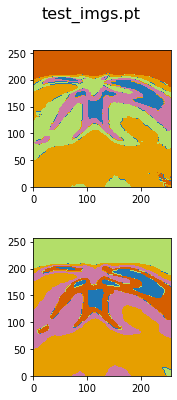

In [8]:
grid = [
    [f"original_{i}" for i in range(n_imgs)],
    [f"rec_{i}" for i in range(n_imgs)],
]
fig, axes = plt.subplot_mosaic(grid, figsize=(12, 6))
fig.subplots_adjust(hspace=0.375)
fig.suptitle(f"{imgName}", fontsize=16)



num_rois_e = (roi_e[1] - roi_e[0]) // roi_e[2]
num_rois_k = (roi_k[1] - roi_k[0]) // roi_k[2]
for grafIndex in range(n_imgs):
    specific_results = results[f"{grafIndex}"]

    # Retrieve the KMeans models
    kmeans_intensities_model = specific_results['kmeans_all']
    cluster_labels_intensities = kmeans_intensities_model.labels_
    # cluster_labels_intensities = specific_results['normalized_intensities']

    cluster_image_all = np.zeros((num_rois_k, num_rois_e))
    k = 0
    roi_y_values = np.zeros_like(cluster_labels_intensities, dtype=float)

    for roi_x in range(num_rois_k):
        for roi_y in range(num_rois_e):
            cluster_image_all[roi_x, roi_y] = np.sum(cluster_labels_intensities[k])
            roi_y_values[k] = roi_y  # Store roi_y value corresponding to each label
            k += 1


    kmeans_intensities_model_rec = specific_results['kmeans_all_rec']
    cluster_labels_intensities = kmeans_intensities_model_rec.labels_
    # cluster_labels_intensities = specific_results['normalized_intensities']

    cluster_image_all_rec = np.zeros((num_rois_k, num_rois_e))
    k = 0
    roi_y_values = np.zeros_like(cluster_labels_intensities, dtype=float)

    for roi_x in range(num_rois_k):
        for roi_y in range(num_rois_e):
            cluster_image_all_rec[roi_x, roi_y] = np.sum(cluster_labels_intensities[k])
            roi_y_values[k] = roi_y  # Store roi_y value corresponding to each label
            k += 1

    # Calculate average and standard deviation of roi_y for each cluster
    average_roi_y = np.zeros(n_clusters)
    std_dev_roi_y = np.zeros(n_clusters)
    average_e = np.zeros(n_clusters)
    std_dev_e = np.zeros(n_clusters)
    for i in range(n_clusters):
        indices = (cluster_labels_intensities == i)
        average_roi_y[i] = np.mean(roi_y_values[indices])
        average_e[i] = d27_E[roi_e[0]] + (d27_E[roi_e[1]] - d27_E[roi_e[0]]) * (0.5 + np.mean(roi_y_values[indices])) /num_rois_e
        std_dev_roi_y[i] = np.std(roi_y_values[indices])
        std_dev_e[i] = (d27_E[roi_e[1]] - d27_E[roi_e[0]]) * np.std(roi_y_values[indices]) / num_rois_e
        #print(f"Cluster {i}: Average roi_y = {average_roi_y[i]:.2f}, Std Dev = {std_dev_roi_y[i]:.2f}")
        print(f"Cluster {i}: Average energy = {average_e[i]:.2f}, Std Dev = {std_dev_e[i]:.2f}")

    # Plotting "All Intensities"
    axes[f"original_{grafIndex}"].imshow(cluster_image_all, cmap=custom_cmap, extent=[d27_k[roi_k[0]], d27_k[roi_k[1]], d27_E[roi_e[1]], d27_E[roi_e[0]]])
    axes[f"rec_{grafIndex}"].imshow(cluster_image_all_rec, cmap=custom_cmap, extent=[d27_k[roi_k[0]], d27_k[roi_k[1]], d27_E[roi_e[1]], d27_E[roi_e[0]]])


    # im_all = ax.imshow(cluster_image_all.T, cmap=custom_cmap, extent=[d27_k[roi_k[0]], d27_k[roi_k[1]], d27_E[roi_e[1]], d27_E[roi_e[0]]])
    # plt.colorbar(im_all, ax=ax, fraction=0.046, pad=0.04)
    # ax.invert_yaxis()
    # ax.set_xlabel(r"$\mathit{k}(\AA^{-1})$")
    # ax.set_ylabel(r"$E-E_{\mathrm{F}}(\mathrm{eV)}$")
    # # plt.savefig('clusters_raw.svg', format='svg')
    # # plt.savefig('clusters_raw.pdf', format='pdf')
    # fig.tight_layout()
    axes[f"original_{grafIndex}"].invert_yaxis()
    axes[f"rec_{grafIndex}"].invert_yaxis()


plt.show()